# Flight delay analysis

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"janvichoudhary","key":""}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d akulbahl/covid19-airline-flight-delays-and-cancellations

 97% 105M/108M [00:01<00:00, 79.7MB/s] 
100% 108M/108M [00:01<00:00, 85.4MB/s]


In [ ]:
!unzip 'covid19-airline-flight-delays-and-cancellations' -d covid-flight-delay

Archive:  covid19-airline-flight-delays-and-cancellations.zip
  inflating: covid-flight-delay/ColumnDescriptions.txt  
  inflating: covid-flight-delay/jantojun2020.csv  


# Importing libraries and exploring the data

In [ ]:
# Importing Libs
import os
import numpy as np # Linear Algebra
import pandas as pd # Data Manipulation

from collections import Counter # Data Manipulation
import seaborn as sns # Data Viz
import matplotlib.pyplot as plt # Data Viz
from sklearn import tree # Modelling a tree
from sklearn.impute import SimpleImputer # Perform Imputation
from imblearn.over_sampling import SMOTE # Perform oversampling
from sklearn.preprocessing import OneHotEncoder # Perform OneHotEnconding
from sklearn.model_selection import StratifiedKFold, cross_val_score,cross_val_predict # Cross Validation
from sklearn.linear_model import LogisticRegression # Modelling
from sklearn.metrics import classification_report, roc_auc_score,precision_score,recall_score # Evaluating the Model


#warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Collecting data
df_2020 = pd.read_csv('/content/covid-flight-delay/jantojun2020.csv')
df_2020.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,MKT_UNIQUE_CARRIER,MKT_CARRIER_FL_NUM,TAIL_NUM,ORIGIN,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2020,1,1,1,3,1/1/2020,WN,5888,N951WN,ONT,...,95.0,122.0,74.0,363,2,8.0,0.0,27.0,0.0,33.0
1,2020,1,1,1,3,1/1/2020,WN,6276,N467WN,ONT,...,90.0,92.0,71.0,363,2,NaN,NaN,NaN,NaN,NaN
2,2020,1,1,1,3,1/1/2020,WN,4598,N7885A,ONT,...,70.0,68.0,57.0,333,2,NaN,NaN,NaN,NaN,NaN
3,2020,1,1,1,3,1/1/2020,WN,4761,N551WN,ONT,...,75.0,75.0,63.0,333,2,NaN,NaN,NaN,NaN,NaN
4,2020,1,1,1,3,1/1/2020,WN,5162,N968WN,ONT,...,80.0,67.0,57.0,333,2,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2745847 entries, 0 to 2745846
Data columns (total 47 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   QUARTER              int64  
 2   MONTH                int64  
 3   DAY_OF_MONTH         int64  
 4   DAY_OF_WEEK          int64  
 5   FL_DATE              object 
 6   MKT_UNIQUE_CARRIER   object 
 7   MKT_CARRIER_FL_NUM   int64  
 8   TAIL_NUM             object 
 9   ORIGIN               object 
 10  ORIGIN_CITY_NAME     object 
 11  ORIGIN_STATE_ABR     object 
 12  ORIGIN_STATE_NM      object 
 13  DEST                 object 
 14  DEST_CITY_NAME       object 
 15  DEST_STATE_ABR       object 
 16  DEST_STATE_NM        object 
 17  CRS_DEP_TIME         int64  
 18  DEP_TIME             float64
 19  DEP_DELAY            float64
 20  DEP_DELAY_NEW        float64
 21  DEP_DEL15            float64
 22  DEP_DELAY_GROUP      float64
 23  DEP_TIME_BLK         object 
 24

In [ ]:
#Dataframe summary
pd.DataFrame({'unicos':df_2020.nunique(),
              'missing': df_2020.isna().sum()/df_2020.count(),
              'tipo':df_2020.dtypes})

,unicos,missing,tipo
YEAR,1,0.000000e+00,int64
QUARTER,2,0.000000e+00,int64
MONTH,6,0.000000e+00,int64
DAY_OF_MONTH,31,0.000000e+00,int64
DAY_OF_WEEK,7,0.000000e+00,int64
FL_DATE,182,0.000000e+00,object
MKT_UNIQUE_CARRIER,10,0.000000e+00,object
MKT_CARRIER_FL_NUM,7003,0.000000e+00,int64
TAIL_NUM,6079,6.307861e-02,object
ORIGIN,375,0.000000e+00,object


In [ ]:
pd.DataFrame({'unicos':df_2020.nunique(),
              'missing': df_2020.isna().mean()*100,
              'tipo':df_2020.dtypes})

,unicos,missing,tipo
YEAR,0,NaN,int64
QUARTER,0,NaN,int64
MONTH,0,NaN,int64
DAY_OF_MONTH,0,NaN,category
DAY_OF_WEEK,0,NaN,category
FL_DATE,0,NaN,object
MKT_UNIQUE_CARRIER,0,NaN,object
MKT_CARRIER_FL_NUM,0,NaN,int64
TAIL_NUM,0,NaN,object
ORIGIN,0,NaN,object


In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [ ]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# jantojun2020.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/content/covid-flight-delay/jantojun2020.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'jantojun2020.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 47 columns


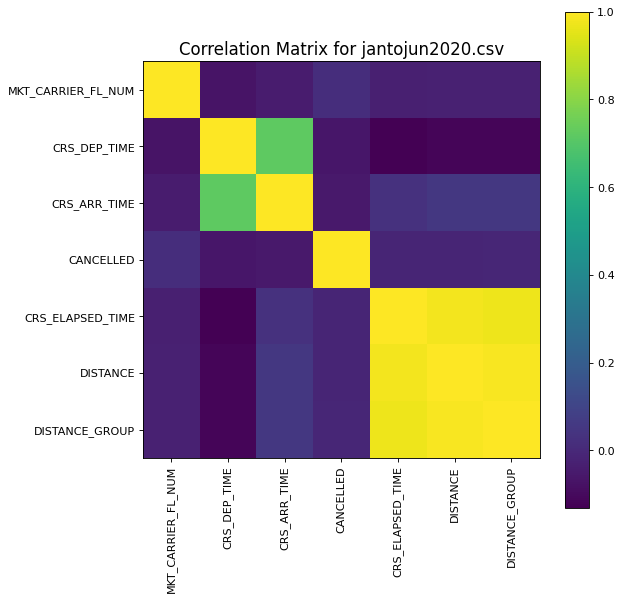

In [ ]:
plotCorrelationMatrix(df1, 8)